In [1]:
from cnn_trainer import main
main()

Train Epoch: 0 [59968/60000 (100%)]	Loss: 0.904496: : 1875it [00:38, 48.70it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.43it/s]



Test set: Average loss: 0.8132, Accuracy: 8401/10000 (84%)



Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.784867: : 1875it [00:34, 53.70it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.54it/s]



Test set: Average loss: 0.7359, Accuracy: 8448/10000 (84%)



Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.753966: : 1875it [00:41, 45.04it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]



Test set: Average loss: 0.7291, Accuracy: 8452/10000 (85%)



Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.631567: : 1875it [00:41, 45.29it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]



Test set: Average loss: 0.7285, Accuracy: 8453/10000 (85%)



Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.832511: : 1875it [00:44, 42.02it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.18it/s]


Test set: Average loss: 0.7285, Accuracy: 8453/10000 (85%)



In [1]:
import torch
from cnn import Net
from cnn_trainer import get_datasets
from matplotlib import pyplot as plt
import numpy as np

In [2]:
dnn = Net()
dnn.load_state_dict(torch.load('mnist_cnn.pt'))
dnn.to('cuda')
dnn.eval()

_, dataset = get_datasets()

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 7], device='cuda:0')


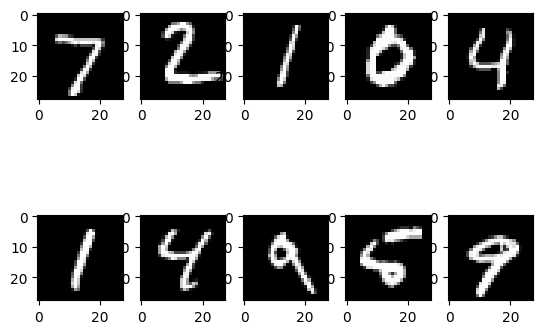

In [3]:
dataset_indices = [0,1,2,3,4,5,6,7,8,9]
xs = []
ys = []
for i, di in enumerate(dataset_indices):
    x, y = dataset[di]
    xs.append(x)
    ys.append(y)
    plt.subplot(2,5,i+1)
    plt.imshow(x.numpy()[0], cmap='gray')
xs = torch.stack(xs).to('cuda')
ys = torch.tensor(ys).to('cuda')
print(ys)
print(dnn(xs).argmax(dim=1, keepdim=True).reshape([10]))
plt.show()

## targeted

In [4]:
targets = torch.tensor([9,8,7,6,5,4,3,2,1,0]).to('cuda')
zeros = torch.zeros(xs.shape).to('cuda')
pred_criterion = torch.nn.NLLLoss()
rec_criterion = torch.nn.MSELoss()

tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], device='cuda:0')


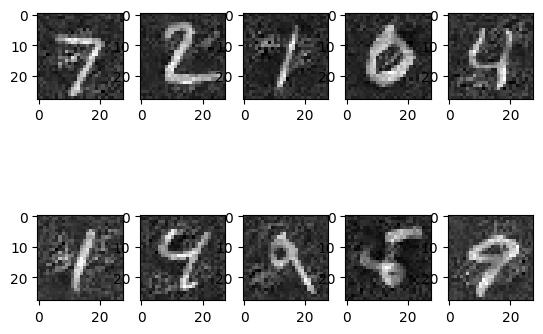

In [24]:
# reload things that need to be reloaded
torch.manual_seed(0)
perturbation = torch.rand(xs.shape).to('cuda')
perturbation.requires_grad_(True)
optimizer = torch.optim.SGD([perturbation], lr=1)
dnn = Net()
dnn.load_state_dict(torch.load('mnist_cnn.pt'))
dnn.to('cuda')

# train
dnn.train()
for i in range(1000):
    optimizer.zero_grad()
    output = dnn(xs + perturbation)
    pred_importance = 0.5
    pred_loss = pred_criterion(output, targets) 
    rec_loss = rec_criterion(perturbation, zeros)
    loss = pred_importance * pred_loss + (1 - pred_importance) * rec_loss
    loss.backward()
    optimizer.step()
dnn.eval()

# see results)
print(dnn(xs + perturbation).argmax(dim=1, keepdim=True).reshape([10]))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow((perturbation[i] + xs[i]).cpu().detach().numpy()[0], cmap='gray')

## untargeted

In [30]:
untargets = ys
zeros = torch.zeros(xs.shape).to('cuda')
pred_criterion = torch.nn.NLLLoss()
rec_criterion = torch.nn.MSELoss()

tensor([7, 3, 2, 0, 4, 1, 7, 6, 4, 7], device='cuda:0')


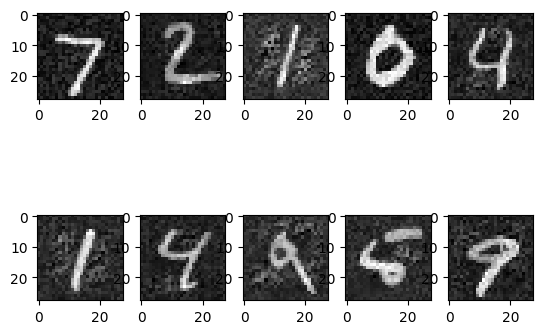

In [45]:
# reload things that need to be reloaded
torch.manual_seed(0)
perturbation = torch.rand(xs.shape).to('cuda')
perturbation.requires_grad_(True)
optimizer = torch.optim.SGD([perturbation], lr=0.5)
dnn = Net()
dnn.load_state_dict(torch.load('mnist_cnn.pt'))
dnn.to('cuda')

# train
dnn.train()
for i in range(3000):
    optimizer.zero_grad()
    output = dnn(xs + perturbation)
    pred_importance = 0.25
    pred_loss = pred_criterion(output, untargets) 
    rec_loss = rec_criterion(perturbation, zeros)
    loss = pred_importance * -1 * pred_loss + (1 - pred_importance) * rec_loss
    loss.backward()
    optimizer.step()
dnn.eval()

# see results)
print(dnn(xs + perturbation).argmax(dim=1, keepdim=True).reshape([10]))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow((perturbation[i] + xs[i]).cpu().detach().numpy()[0], cmap='gray')

## gradient inversion
not exactly adversarial examples but somewhat related. since i already have the framework for it.

In [ ]:
targets = torch.tensor([9,8,7,6,5,4,3,2,1,0]).to('cuda')
pred_criterion = torch.nn.NLLLoss()


tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], device='cuda:0')


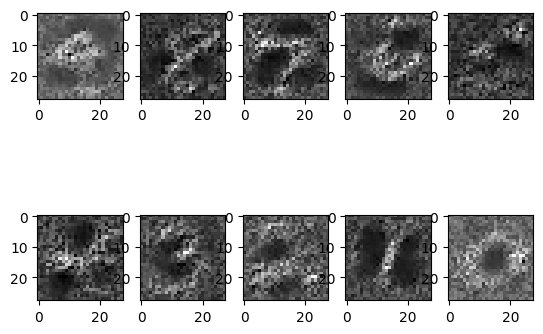

In [48]:
# reload things that need to be reloaded
torch.manual_seed(0)
perturbation = torch.rand(xs.shape).to('cuda')
perturbation.requires_grad_(True)
optimizer = torch.optim.SGD([perturbation], lr=0.1)
dnn = Net()
dnn.load_state_dict(torch.load('mnist_cnn.pt'))
dnn.to('cuda')

# train
dnn.train()
for i in range(10000):
    optimizer.zero_grad()
    output = dnn(perturbation)
    loss = pred_criterion(output, targets)
    loss.backward()
    optimizer.step()
dnn.eval()

# see results)
print(dnn(perturbation).argmax(dim=1, keepdim=True).reshape([10]))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow((perturbation[i]).cpu().detach().numpy()[0], cmap='gray')